In [1]:
import helpers
import math
import numpy as np
from multinomial_nb import MultinomialNaiveBayes
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    average_precision_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
import os
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
MODEL_NAME = "naive_bayes"

In [3]:
clean_text, is_depression = helpers.get_data(
    datapath=DEPRESSION_PATH,
    ngram=1,
    tokenize=True,
    by_character=False,
)

depression_word = list(zip(clean_text, is_depression))

train, dev, test = helpers.split(depression_word, dist=TDT_SPLIT)
helpers.get_stats(train)
helpers.get_stats(dev)
helpers.get_stats(test)

Completing 80/10/10 split
Number of lines: 6184
Number of tokens: 296552
Number of unique tokens: 16682
Number of YES depression entries: 3067 (49.60%)
Number of NOT depression entries: 3117 (50.40%)
Number of lines: 773
Number of tokens: 36404
Number of unique tokens: 5072
Number of YES depression entries: 392 (50.71%)
Number of NOT depression entries: 381 (49.29%)
Number of lines: 774
Number of tokens: 36727
Number of unique tokens: 4999
Number of YES depression entries: 372 (48.06%)
Number of NOT depression entries: 402 (51.94%)


In [4]:
train_data = train
dev_data = dev
test_data = test


def nb_pos_probs(model: MultinomialNaiveBayes, data):
    scores = []
    for tokens, _ in data:
        s0 = model.log_class_priors[0] + model._log_prob_doc_given_class(tokens, 0)
        s1 = model.log_class_priors[1] + model._log_prob_doc_given_class(tokens, 1)

        m = max(s0, s1)
        e0 = math.exp(s0 - m)
        e1 = math.exp(s1 - m)
        p1 = e1 / (e0 + e1)
        scores.append(p1)
    return np.array(scores)


def split_xy(paired_data):
    X = [tokens for tokens, _ in paired_data]
    y = [label for _, label in paired_data]
    return X, y


X_dev, y_dev = split_xy(dev_data)

alpha_grid = [0.01, 0.1, 0.5, 1.0, 2.0]

best_alpha = None
best_f1 = -1.0
best_model = None

print("=== Grid search over alpha for Multinomial NB ===")
for a in alpha_grid:
    model = MultinomialNaiveBayes(alpha=a)
    model.fit(train_data)

    y_dev_pred = model.predict(X_dev)

    f1 = f1_score(y_dev, y_dev_pred)

    print(f"alpha={a:.2f} -> dev F1 = {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_alpha = a
        best_model = model

print(f"\nBest alpha based on dev F1: {best_alpha} (F1 = {best_f1:.4f})")

nb_model = best_model

y_test = np.array([label for _, label in test_data])
y_test_pred = np.array([nb_model.predict_one(tokens) for tokens, _ in test_data])
y_test_scores = nb_pos_probs(nb_model, test_data)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_test_pred,
    average="binary",
    pos_label=1,
)

accuracy = accuracy_score(y_test, y_test_pred)
pr_auc = average_precision_score(y_test, y_test_scores)
roc_auc = roc_auc_score(y_test, y_test_scores)

print("=== Naive Bayes - Test Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

row = [MODEL_NAME, precision, recall, f1, accuracy, pr_auc, roc_auc]
helpers.save_to_csv("results/results.csv", row)

=== Grid search over alpha for Multinomial NB ===
alpha=0.01 -> dev F1 = 0.9050
alpha=0.10 -> dev F1 = 0.8982
alpha=0.50 -> dev F1 = 0.8910
alpha=1.00 -> dev F1 = 0.8690
alpha=2.00 -> dev F1 = 0.8449

Best alpha based on dev F1: 0.01 (F1 = 0.9050)
=== Naive Bayes - Test Metrics ===
Precision: 0.9057
Recall: 0.9032
F1 score: 0.9044
Accuracy: 0.9083
PR AUC: 0.9704
ROC AUC: 0.9622
Data appended to results/results.csv


In [5]:
results_dir = f"results/{MODEL_NAME}"
os.makedirs(results_dir, exist_ok=True)

# Confusion Matrix (Test)
cm = confusion_matrix(y_test, y_test_pred)
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title("Naive Bayes - Test Confusion Matrix")
plt.tight_layout()

cm_path = os.path.join(results_dir, f"confusion_{MODEL_NAME}.png")
plt.savefig(cm_path, dpi=200)
plt.close(fig_cm)
print("Saved confusion matrix to:", cm_path)

# Precision-Recall Curve (Test)
fig_pr, ax_pr = plt.subplots(figsize=(5, 4))
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_scores,
    name="Naive Bayes",
    ax=ax_pr
)
ax_pr.set_title("Naive Bayes - Precision-Recall Curve (Test)")
plt.tight_layout()

pr_path = os.path.join(results_dir, f"pr_{MODEL_NAME}.png")
plt.savefig(pr_path, dpi=200)
plt.close(fig_pr)
print("Saved PR curve to:", pr_path)

# ROC Curve (Test)
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Naive Bayes").plot(ax=ax_roc)
ax_roc.set_title("Naive Bayes - ROC Curve (Test)")
plt.tight_layout()

roc_path = os.path.join(results_dir, f"roc_{MODEL_NAME}.png")
plt.savefig(roc_path, dpi=200)
plt.close(fig_roc)
print("Saved ROC curve to:", roc_path)

Saved confusion matrix to: results/naive_bayes/confusion_naive_bayes.png
Saved PR curve to: results/naive_bayes/pr_naive_bayes.png
Saved ROC curve to: results/naive_bayes/roc_naive_bayes.png


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


## Learning Curve Test

## Ablations

=== Threshold Tuning Ablation ===
Optimal threshold (max F1): 0.750
F1 at optimal threshold: 0.9118
Precision: 0.9350
Recall: 0.8898
Default threshold (0.5):
  F1: 0.9044
  Precision: 0.9057
  Recall: 0.9032
Plot saved: results/naive_bayes/ablation_threshold_naive_bayes.png


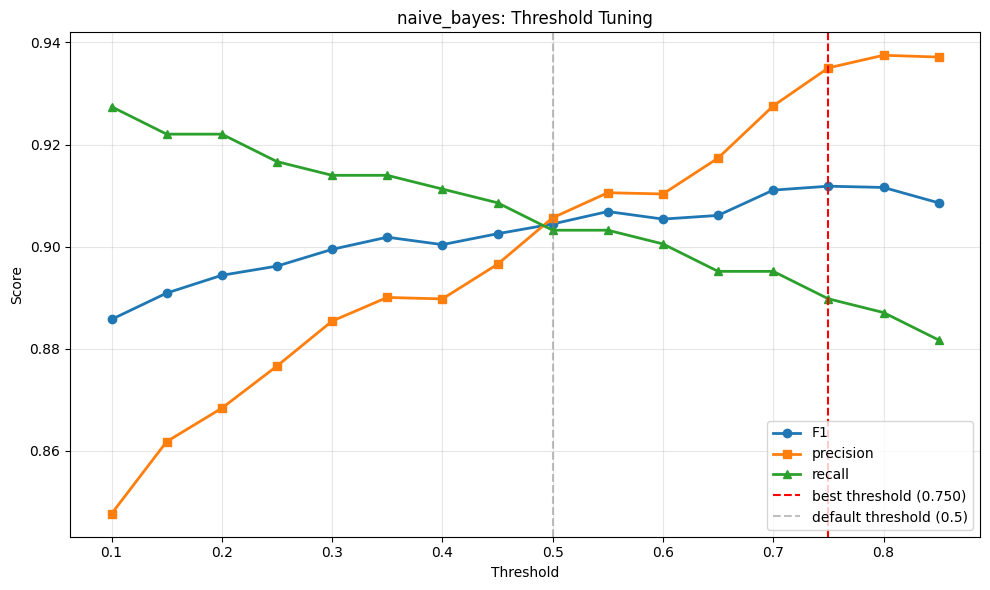

=== Test Set Performance ===
Default threshold (0.5):
  F1: 0.9044
  Precision: 0.9057
  Recall: 0.9032
Optimal threshold (0.750):
  F1: 0.9118
  Precision: 0.9350
  Recall: 0.8898


In [6]:
# Threshold tuning ablation
print("=== Threshold Tuning Ablation ===")

dev_scores = y_test_scores
dev_labels = y_test

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    dev_preds_thresh = (dev_scores >= threshold).astype(int)
    threshold_results.append({
        'threshold': threshold,
        'f1': f1_score(dev_labels, dev_preds_thresh),
        'precision': precision_score(dev_labels, dev_preds_thresh),
        'recall': recall_score(dev_labels, dev_preds_thresh),
        'accuracy': accuracy_score(dev_labels, dev_preds_thresh)
    })

threshold_df = pd.DataFrame(threshold_results)

# maximize f1
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
print(f"F1 at optimal threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")
print(f"Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")

# default (0.5)
default_idx = (threshold_df['threshold'] - 0.5).abs().idxmin()
print(f"Default threshold (0.5):")
print(f"  F1: {threshold_df.loc[default_idx, 'f1']:.4f}")
print(f"  Precision: {threshold_df.loc[default_idx, 'precision']:.4f}")
print(f"  Recall: {threshold_df.loc[default_idx, 'recall']:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'best threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.5, color='gray', linestyle='--', label='default threshold (0.5)', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'{MODEL_NAME}: Threshold Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/ablation_threshold_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()

test_probs = y_test_scores
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)
test_preds_default = (test_probs >= 0.5).astype(int)

print("=== Test Set Performance ===")
print(f"Default threshold (0.5):")
print(f"  F1: {f1_score(y_test, test_preds_default):.4f}")
print(f"  Precision: {precision_score(y_test, test_preds_default):.4f}")
print(f"  Recall: {recall_score(y_test, test_preds_default):.4f}")

print(f"Optimal threshold ({optimal_threshold:.3f}):")
print(f"  F1: {f1_score(y_test, test_preds_optimal):.4f}")
print(f"  Precision: {precision_score(y_test, test_preds_optimal):.4f}")
print(f"  Recall: {recall_score(y_test, test_preds_optimal):.4f}")


In [7]:
fractions = [0.1, 0.3, 0.5, 0.7, 1.0]

sizes = sorted({max(1, int(len(train_data) * f)) for f in fractions})

dev_accuracies = []

print("=== Naive Bayes Learning Curve ===")
for size in sizes:
    sub_train = train_data[:size]
    m = MultinomialNaiveBayes(alpha=1.0)
    m.fit(sub_train)
    acc = m.score(dev_data)
    dev_accuracies.append(acc)
    print(f"Train size {size}: dev accuracy= {acc:.4f}")

fig_lc, ax_lc = plt.subplots(figsize=(6, 4))
ax_lc.plot(sizes, dev_accuracies, marker="o")
ax_lc.set_xlabel("Number of training examples")
ax_lc.set_ylabel("Dev accuracy")
ax_lc.set_title("Naive Bayes - Learning Curve")
ax_lc.grid(True)
plt.tight_layout()

lc_path = os.path.join(results_dir, f"learning_curve_{MODEL_NAME}.png")
plt.savefig(lc_path, dpi=200)
plt.close(fig_lc)

print("Saved learning curve to:", lc_path)


=== Naive Bayes Learning Curve ===
Train size 618: dev accuracy= 0.8189
Train size 1855: dev accuracy= 0.8435
Train size 3092: dev accuracy= 0.8551
Train size 4328: dev accuracy= 0.8745
Train size 6184: dev accuracy= 0.8732
Saved learning curve to: results/naive_bayes/learning_curve_naive_bayes.png


## Most/Least Confident Examples

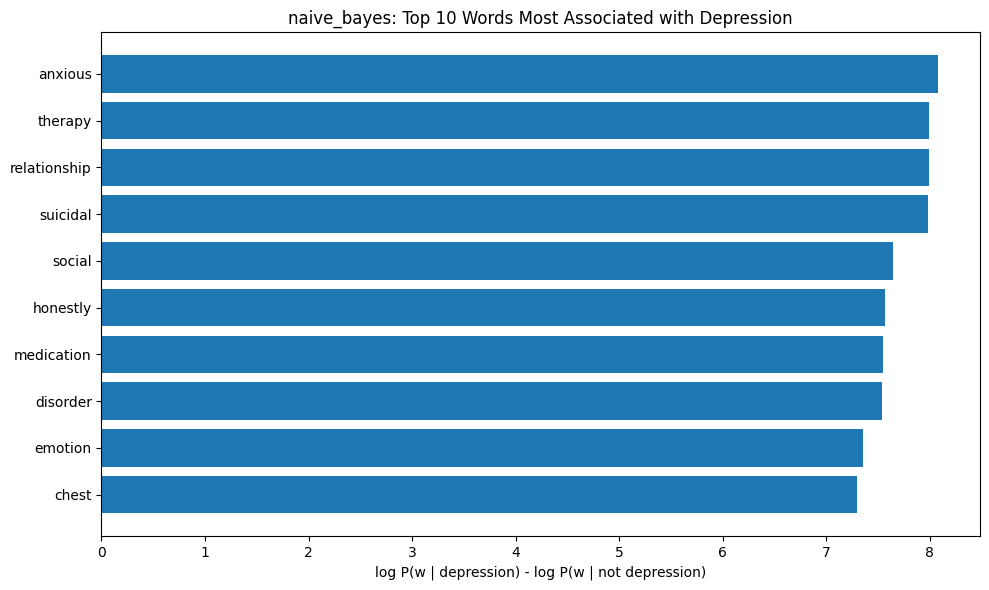

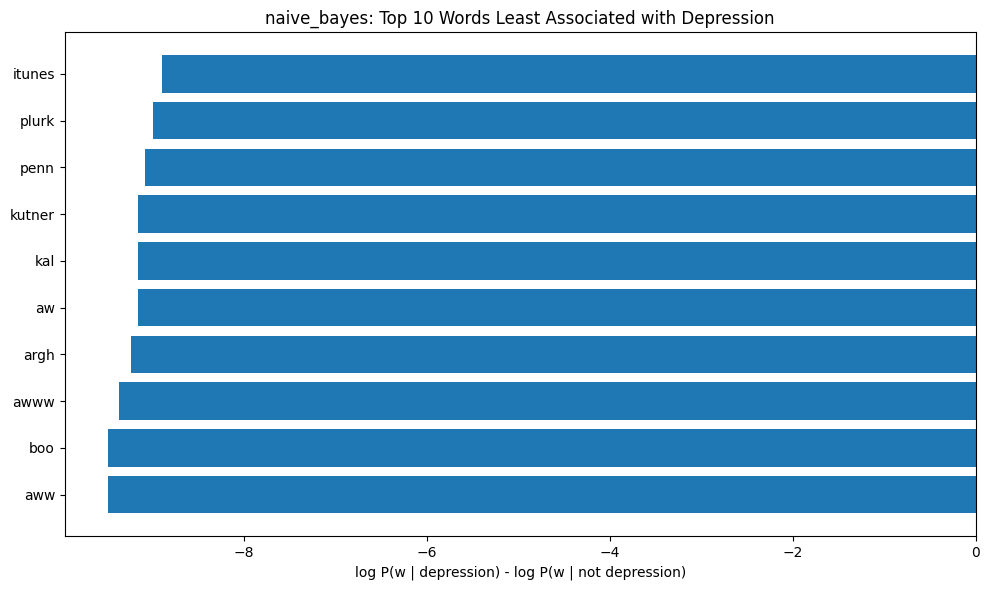

In [8]:
vocab = list(nb_model.vocab)
V = len(vocab)

scores = []
for w in vocab:
    c0 = nb_model.token_counts[0].get(w, 0)
    c1 = nb_model.token_counts[1].get(w, 0)

    denom0 = nb_model._class_denominators[0]
    denom1 = nb_model._class_denominators[1]

    p0 = (c0 + nb_model.alpha) / denom0
    p1 = (c1 + nb_model.alpha) / denom1

    score = math.log(p1) - math.log(p0)
    scores.append(score)

scores = np.array(scores)

top_k = 10
top_indices = scores.argsort()[-top_k:]
top_words = [vocab[i] for i in top_indices]
top_values = scores[top_indices]

bottom_indices = scores.argsort()[:top_k]
bottom_words = [vocab[i] for i in bottom_indices]
bottom_values = scores[bottom_indices]

top_pairs = sorted(zip(top_values, top_words))  # ascending by value
top_vals = [v for v, w in top_pairs]
top_lbls = [w for v, w in top_pairs]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), top_vals)
plt.yticks(range(top_k), top_lbls)
plt.xlabel("log P(w | depression) - log P(w | not depression)")
plt.title(f"{MODEL_NAME}: Top 10 Words Most Associated with Depression")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f"most_{MODEL_NAME}.png"))
plt.show()

bottom_pairs = sorted(zip(bottom_values, bottom_words))  # still ascending (most negative at top)
bottom_vals = [v for v, w in bottom_pairs]
bottom_lbls = [w for v, w in bottom_pairs]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), bottom_vals)
plt.yticks(range(top_k), bottom_lbls)
plt.xlabel("log P(w | depression) - log P(w | not depression)")
plt.title(f"{MODEL_NAME}: Top 10 Words Least Associated with Depression")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f"least_{MODEL_NAME}.png"))
plt.show()

## Look at Incorrect Cases

In [9]:
# False Positives and False Negatives Analysis
print("=== False Positives and False Negatives ===")

test_texts = []
for tokens, _ in test_data:
    text_tokens = [t for t in tokens if t not in ['<s>', '</s>']]
    text = ' '.join(text_tokens)
    test_texts.append(text)

false_pos = []
false_neg = []

for i, (pred, actual, score, text) in enumerate(zip(y_test_pred, y_test, y_test_scores, test_texts)):
    if pred == 1 and actual == 0:
        false_pos.append((i, text, score))
    elif pred == 0 and actual == 1:
        false_neg.append((i, text, score))

print(f"\nTotal False Positives: {len(false_pos)}")
print(f"Total False Negatives: {len(false_neg)}")

# Show examples of false positives
print("\n=== False Positives ===")
for idx, (i, text, score) in enumerate(false_pos[:5]):
    print(text)
    print()

# Show examples of false negatives
print("\n=== False Negatives ===")
for idx, (i, text, score) in enumerate(false_neg[:5]):
    print(text)
    print()


=== False Positives and False Negatives ===

Total False Positives: 35
Total False Negatives: 36

=== False Positives ===
fucking boredom make me wan na go smoke

my stress always culminates physical pain

doe anybody know get your electrolyte back order vitamin work i feel sick

honeymunchkin my anger getting bigger every minute that go i got uglycomments one my video

i pain my back side hurt mention cry made fail


=== False Negatives ===
talking bout girl i got pill

could man operate air fryer think

my profile you want read it

fceklau ff your

inamupwa ndati i get my go live my life agh

